# Imports

In [1]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import MinMaxScaler

TESTING = False

# Classe que representa uma MLP

Implementado de uma maneira vetorizada por mini batch. 

In [2]:
class MLP(): 
    def __init__(self, dimensions=[], momentum=0.9, classification=True, 
                 lr=0.1, testing=False, use_relu=False):
        self.lr = lr
        self.velocities = []
        self.momentum = momentum
        self.classification = classification
        
        # Initialize fully connected layers
        self.layers = []
        for idx, (input_dim, output_dim) in enumerate(dimensions, 1):
            self.layers.append(self.Linear(input_dim, output_dim))
            # For each linear layer, add a velocity term starting at 0
            self.velocities.append(np.zeros((input_dim, output_dim)))
            if idx != len(dimensions):
                if use_relu:
                    self.layers.append(self.ReLU())
                else:
                    self.layers.append(self.Sigmoid())
            else: # Last layer
                if self.classification:
                    self.layers.append(self.Softmax()) # for the last use softmax
            
        if classification:
            self.cost = self.CrossEntropy()
        else:
            self.cost = self.SquareLoss()
        
    class ReLU():
        def forward(self, x):
            self.old_x = np.copy(x)
            return np.clip(x,0,None)

        def backward(self, grad):
            return np.where(self.old_x>0,grad,0)        
        
    class Sigmoid():
        def forward(self, x):
            # Cip the sigmoid to avoid overflow
            # See https://stackoverflow.com/questions/23128401/overflow-error-in-neural-networks-implementation
            clipped_x = np.clip(x, -500, 500)
            self.old_y = np.exp(clipped_x) / (1. + np.exp(clipped_x))
            return self.old_y

        def backward(self, grad):
            return self.old_y * (1. - self.old_y) * grad

    class Softmax():
        def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

        def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

    class CrossEntropy():
        def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

        def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)
    
    class SquareLoss():
        def forward(self,x,y, clip=True):
            """We expect the output y to be normalized, therefore
            we clip x to -10, 10. This avoids exploding values in the first
            forward pass.
            
            Since the normalization should give use numbers between -1 and +1, 
            -10 and +10 are good extremes values.
            """
            if clip:
                self.old_x = x.clip(-10, 10)
            else:
                self.old_x = x
            self.old_y = y
            return (self.old_x - self.old_y)**2

        def backward(self):
            return 2*(self.old_x - self.old_y)

    class Linear():
        def __init__(self,n_in,n_out):
            self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
            self.biases = np.zeros(n_out)

            self.w_vel = np.zeros((n_in,n_out))
            self.b_vel = np.zeros(n_out)

        def update_velocity(self, w_vel, b_vel):
            self.w_vel = w_vel
            self.b_vel = b_vel

        def forward(self, x):
            self.old_x = x
            return np.dot(x,self.weights) + self.biases

        def backward(self,grad):
            self.grad_b = grad.mean(axis=0)
            self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
            return np.dot(grad,self.weights.transpose())

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
            
    def fit(self, x, y, n_iter=100, mini_batch=32):
        for _ in range(n_iter):   
            total_loss = 0
            for start_idx in range(0, len(x), mini_batch):
                x_batch = x[start_idx:start_idx+mini_batch]
                y_batch = y[start_idx:start_idx+mini_batch]   
                
                # Forward and backward
                loss = self.loss(x_batch,y_batch)
                total_loss += loss.sum()
                self.backward()
                
                # Update according to momentum
                for layer in self.layers:
                    if type(layer) == self.Linear:
                        new_w_vel = self.momentum*layer.w_vel - self.lr*layer.grad_w
                        new_b_vel = self.momentum*layer.b_vel - self.lr*layer.grad_b
                        
                        layer.weights += new_w_vel
                        layer.weights += new_b_vel
                        
                        layer.update_velocity(new_w_vel, new_b_vel)

    def predict(self, x):
        output = self.forward(x)
        if self.classification:
            return output.argmax(axis=-1)                       
        else:
            return output



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Funções auxiliares

Diversas funções que seram utilizadas para ambos os datasets

Função para carregar os dados

In [3]:
def load_and_analyze(filename, target, header=0):
    df = pd.read_csv(filename, header=header)
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True) 
    
    # Check for nulls
    print(f"Temos {df.isna().sum().sum()} nulos na nossa tabela")
    
    if target == "category":
        df["category"] = df["category"].map({"Bad":0, "Mid":1, "Good":2})
        sns.countplot(df["category"])
        x = df.drop(columns=[target])
        y = df[target]
    else:
        x = df.iloc[:, :-2]
        y1 = df.iloc[:, -1]
        y2 = df.iloc[:, -2]
        y = [y1, y2]
        sns.distplot(y1, hist=False)
        plt.show()
        sns.distplot(y2, hist=False)
    plt.show()
    return x, y


Função  para normalizar os dados que vamos utilizar posteriormente

In [4]:
def normalize_data(x_train, x_test, y=None):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    
    if y is not None:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        y = scaler.fit_transform(y)
        return x_train_norm, x_test_norm, scaler, y
    else:
        return x_train_norm, x_test_norm

Função para rodar 1 experimento

In [5]:
def run_experiment(x, y, test_percent, hidden_layers, cicles, lr, momentum,
                  classification=True):
    start_time = time.time()
    
    # Process our data and normalize
    if classification:
        y_dummies = pd.get_dummies(y)
    else:
        y_dummies = y.values.reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(x, y_dummies, stratify=y, 
                                                       test_size=test_percent)
    x_train, x_test = normalize_data(x_train, x_test)

    # Create model
    dimensions = [(x.shape[1], 32)]
    if hidden_layers == 2:
        dimensions += [(32, 4), (4, y_dummies.shape[1])]
    elif hidden_layers == 3:
        dimensions += [(32, 8), (8, 4), (4, y_dummies.shape[1])]
    else:
        dimensions += [(32, y_dummies.shape[1])]
    mlp = MLP(dimensions=dimensions, momentum=momentum, lr=lr, 
             classification=classification)
    
    # Train and evaluate
    if classification:
        mlp.fit(x_train, y_train.values, n_iter=cicles)
    else:
        mlp.fit(x_train, y_train, n_iter=cicles)
    preds = mlp.predict(x_test)
    
    if classification:
        score = accuracy_score(y_test.values.argmax(axis=-1), preds)
    else:
        score = mean_squared_error(y_test, preds)
    end_time = time.time()
    
    return score, end_time-start_time
    

Roda todos os nossos experimentos

In [6]:
def run_various_experiments(x, y, classification=True):
    # Default values
    cols = ["hidden_layers", "cicles", "momentum", "lr", "test_percent"]
    temp = [1, 1000, 0.9, 0.1, 0.3]
    default = {col:val for col, val in zip(cols, temp)}

    # Values to be tested
    temp = [ [1, 2, 3], [100, 1000, 10000], [0.5, 0.7, 0.9],
            [0.01, 0.1, 1], [0.3, 0.5, 0.7]]
    test_values = {col:val for col, val in zip(cols, temp)}

    # Dictionary of results
    if classification:
        results_cols = ["Accuracy"]
    else:
        results_cols = ["MSE"]
    results_cols += ["Time", "Value"]
    results = {col:pd.DataFrame(columns=results_cols) 
                   for col in cols}

    for name, values in test_values.items():
        params = {key:value for key, value in default.items() if key != name}
        params["classification"] = classification
        if TESTING: # A global testing flag for quickly prototyping
            params["cicles"] = 1
        for value in values:
            if TESTING and name == "cicles":
                break
            params[name] = value
            acc, runtime = run_experiment(x, y, **params)
            results[name].loc[len(results[name])] = [acc, runtime, value]
    return results



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Classificação - winequality-red.csv 

Temos 0 nulos na nossa tabela


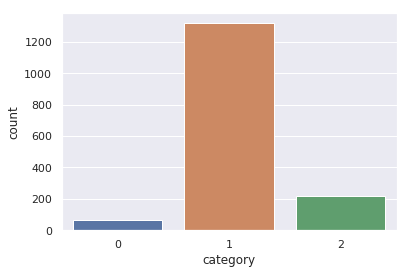

In [42]:
TARGET = "category"
x, y = load_and_analyze("winequality-red.csv", target=TARGET)

Como nosso problema é altamente desbalanceado, vamos usar a mesma quantidade de elementos de cada classe, balanceando pela a classe mínima.

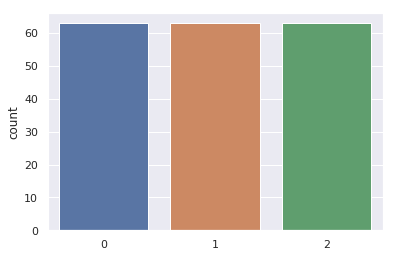

In [43]:
amount = (y == 0).sum()
valid_idxs = pd.Series()
for i in range(3):
    valid = y[y==i].sample(amount)
    valid_idxs = valid_idxs.append(valid)
sns.countplot(valid_idxs)

In [44]:
x = x.loc[valid_idxs.index]
y = y.loc[valid_idxs.index]

In [45]:
results = run_various_experiments(x, y)

In [46]:
results["hidden_layers"]

,Accuracy,Time,Value
0,0.315789,1.566741,1.0
1,0.333333,1.988834,2.0
2,0.368421,2.501727,3.0


In [47]:
results["cicles"]

,Accuracy,Time,Value
0,0.508772,0.159919,100.0
1,0.368421,1.559813,1000.0
2,0.368421,15.558832,10000.0


In [48]:
results["momentum"]

,Accuracy,Time,Value
0,0.508772,1.566140,0.5
1,0.578947,1.557934,0.7
2,0.350877,1.561336,0.9


In [49]:
results["lr"]

,Accuracy,Time,Value
0,0.561404,1.561039,0.01
1,0.403509,1.569736,0.10
2,0.333333,1.585565,1.00


In [50]:
results["test_percent"]

,Accuracy,Time,Value
0,0.350877,1.566538,0.3
1,0.421053,0.989756,0.5
2,0.473684,0.646378,0.7


In [64]:
# Format the data to be generated in our report, using https://www.tablesgenerator.com/
table = pd.DataFrame(columns=["Value"])

for key, item in results.items():
    for index, data in item.iterrows():
        name = key + "=" + str(data["Value"])
        value = data["Accuracy"]
        table.loc[name] = data["Accuracy"]
        print(f"{name}\t{100*value:.2f}%")

hidden_layers=1.0	31.58%
hidden_layers=2.0	33.33%
hidden_layers=3.0	36.84%
cicles=100.0	50.88%
cicles=1000.0	36.84%
cicles=10000.0	36.84%
momentum=0.5	50.88%
momentum=0.7	57.89%
momentum=0.9	35.09%
lr=0.01	56.14%
lr=0.1	40.35%
lr=1.0	33.33%
test_percent=0.3	35.09%
test_percent=0.5	42.11%
test_percent=0.7	47.37%


                      Value
hidden_layers=1.0  0.315789
hidden_layers=2.0  0.333333
hidden_layers=3.0  0.368421
cicles=100.0       0.508772
cicles=1000.0      0.368421
cicles=10000.0     0.368421
momentum=0.5       0.508772
momentum=0.7       0.578947
momentum=0.9       0.350877
lr=0.01            0.561404
lr=0.1             0.403509
lr=1.0             0.333333
test_percent=0.3   0.350877
test_percent=0.5   0.421053
test_percent=0.7   0.473684




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Regressão - default_features_1059_tracks.txt

Temos 0 nulos na nossa tabela


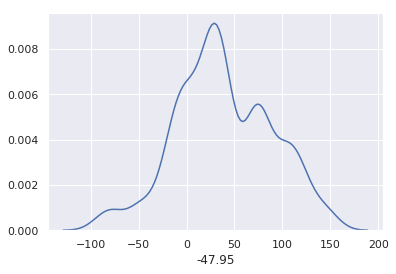

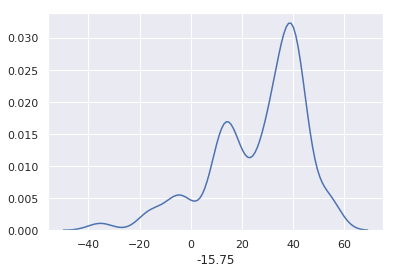

In [16]:
x, (y1, y2) = load_and_analyze("default_features_1059_tracks.txt", target="69")

In [17]:
all_results = []
for y in [y1, y2]:
    y_scaler = MinMaxScaler(feature_range=(-1, +1))
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
    y_scaled = pd.Series(y_scaled.reshape(-1))
    
    all_results.append(run_various_experiments(x, y_scaled, classification=False))

In [88]:
# SHow the results
table = pd.DataFrame(columns=[f"MSE-{x}" for x in names])
for results_i, col_name in zip(all_results,names):
    for key, item in results_i.items():
        for index, data in item.iterrows():
            name = key + "=" + str(data["Value"])
            value = data["MSE"]
            table.loc[name, f"MSE-{col_name}"] = value
#table[table>2] = "X"
table.head()

,MSE-Latitude,MSE-Longitude
hidden_layers=1.0,3206.35,10847.4
hidden_layers=2.0,0.176923,0.190386
hidden_layers=3.0,0.175278,0.166236
cicles=100.0,10240.1,7787.6
cicles=1000.0,4209.33,403.056


In [90]:
# Format the data to be generated in our report, using https://www.tablesgenerator.com/
for index, data in table.iterrows():
    print(index, end="\t")
    for x in data:
        if x > 2: print("X", end="\t")
        else: print(f"{x:.2f}", end="\t")
    print()

hidden_layers=1.0	X	X	
hidden_layers=2.0	0.18	0.19	
hidden_layers=3.0	0.18	0.17	
cicles=100.0	X	X	
cicles=1000.0	X	X	
cicles=10000.0	X	X	
momentum=0.5	X	X	
momentum=0.7	X	X	
momentum=0.9	X	X	
lr=0.01	0.19	0.14	
lr=0.1	X	X	
lr=1.0	X	X	
test_percent=0.3	X	X	
test_percent=0.5	X	X	
test_percent=0.7	X	X	
